In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib import legacy_seq2seq

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11842675700725631814
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 5314314240
locality {
  bus_id: 1
}
incarnation: 4046884581449423603
physical_device_desc: "device: 0, name: GeForce GTX 980 Ti, pci bus id: 0000:01:00.0"
]


# Process Joint Labels

In [3]:
directory = 'labels/'
frames = []
for filename in os.listdir(directory):
    annotations = loadmat(directory + filename)
    if annotations['action'][0] == 'squat':
        # Create Nx13x2 joint labels for each video
        frames.append(np.stack([annotations['x'], annotations['y']], axis=2))

In [4]:
# Keep only videos with more than 70 image frames
top_frames = []
for i in range(231):
    if frames[i].shape[0] > 70:
        top_frames.append(frames[i])


frames_train = [top_frames[0]]
frames_test = top_frames[150:]

In [5]:
len(top_frames)

185

# LSTM Params

In [6]:
L = 13 # num of joints
k = 50 # training num
T = 10 # prediction num
H = 1024 # hidden layer size

In [9]:
def RNN(p, weights, biases):
    # p should be shape (batch_size, T, 2 * L)
    # unstack gets us a list of T (batch_size, 2 * L) tensors
    stacked_lstm = rnn.MultiRNNCell([rnn.BasicLSTMCell(H, forget_bias=1.0) for _ in range(2)])
    batch_size = tf.shape(p)[0]
    p = tf.unstack(p, k, axis=1)
    outputs, states = legacy_seq2seq.basic_rnn_seq2seq(p,  [p[-1]]*T, stacked_lstm)
    
    # outputs is a list of T (batch_size, H) arrays
    # concat outputs is (batch_size * T, H)
    concat_outputs = tf.concat(outputs, axis=0)
    
    # predictions is (batch_size * T, 2 * L)
    predictions = tf.matmul(concat_outputs, weights) + biases
    
    # reshape into (T, batch_size, 2 * L) then transpose into (batch_size, T, 2 * L)
    return tf.transpose(tf.reshape(predictions, (T, batch_size, L * 2)), perm=[1, 0, 2])

In [10]:
tf.reset_default_graph()

# Parameters
learning_rate = 0.001
epochs = 2000
batch_size = 10
n_videos = len(frames_train)
display_step = 50

p_input = tf.placeholder(tf.float32, shape=[None, k, L*2])
p_output = tf.placeholder(tf.float32, shape=[p_input.get_shape()[0], T, L*2])

W = tf.get_variable('W', shape=[H, L*2], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b', shape=[L*2], dtype=tf.float32, initializer=tf.zeros_initializer())

p_output_predicted = RNN(p_input, W, b)

# Define loss and optimizer
loss = tf.reduce_mean(tf.squared_difference(p_output_predicted, p_output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# LSTM Training/Validation

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# saver = tf.train.Saver()
# saver.restore(sess, 'lstm-reg-20000')
mean_losses = []
for epoch in range(epochs):
    total_iter = n_videos // batch_size
    total_iter = 1
    total_loss = 0
    for i in range(total_iter):
        inputs = []
        expected_outputs = []
        for frame in frames_train:
            start_time =  np.random.randint(frame.shape[0] - (k + T) + 1)
            inputs.append(frame[start_time : start_time + k].reshape(k, 2 * L))
            expected_outputs.append(frame[start_time + k : start_time + k + T].reshape(T, 2 * L))
        _, loss_value = sess.run((optimizer, loss), feed_dict={ p_input : np.asarray(inputs), p_output : np.asarray(expected_outputs) })
        total_loss += loss_value
    mean_loss = total_loss / total_iter
    mean_losses.append(mean_loss)
    if (epoch + 1) % display_step == 0:
        print('epoch %s: loss=%.4f' % (epoch + 1, mean_loss))

epoch 50: loss=19680.8945
epoch 100: loss=9186.8867
epoch 150: loss=6345.3774
epoch 200: loss=2791.2385
epoch 250: loss=1359.3522
epoch 300: loss=750.0790
epoch 350: loss=260.6786
epoch 400: loss=178.7072
epoch 450: loss=121.1581
epoch 500: loss=49.6798
epoch 550: loss=402.5173
epoch 600: loss=16.3720
epoch 650: loss=118.3894
epoch 700: loss=8.9969
epoch 750: loss=425.2588
epoch 800: loss=97.8069


KeyboardInterrupt: 

In [15]:
inputs = []
expected_outputs = []
for frame in frames_train:
    start_time =  np.random.randint(frame.shape[0] - (k + T) + 1)
    inputs.append(frame[start_time : start_time + k].reshape(k, 2 * L))
    expected_outputs.append(frame[start_time + k : start_time + k + T].reshape(T, 2 * L))

output = sess.run((p_output_predicted), feed_dict={ p_input : np.asarray(inputs)})


In [16]:
for i in range(T):
    print(np.mean(np.linalg.norm(
        output.reshape((1, T, 13, 2))[:,i,:,:] - np.array(expected_outputs).reshape((1, T, 13, 2))[:,i,:,:],
        axis=2)))

4.7266137076
5.26089593657
5.7321359288
6.2687101831
6.66876115577
7.07075108717
7.56185030623
7.93553100698
8.20991971586
8.51644090664


T =  0


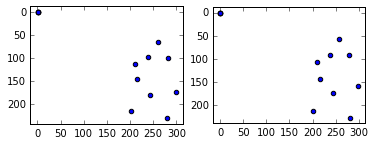

T =  1


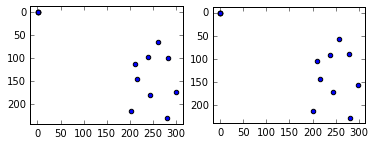

T =  2


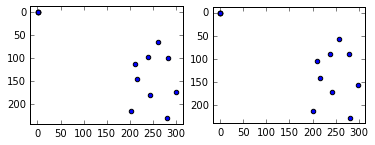

T =  3


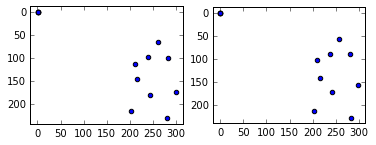

T =  4


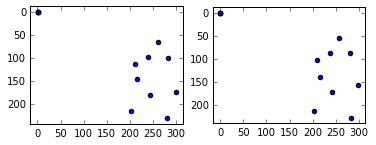

T =  5


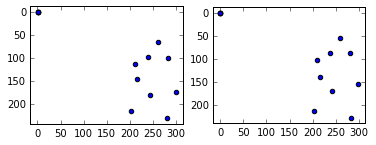

T =  6


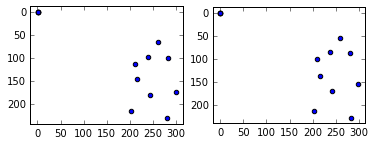

T =  7


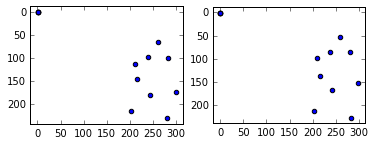

T =  8


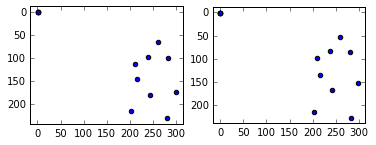

T =  9


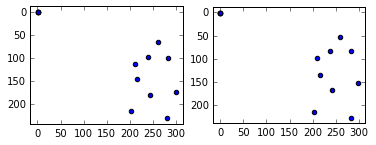

In [17]:
for i in range(T):
    if i % 1 == 0:
        image = i
        print('T = ', i)
        plt.subplot(1,2,1)
        plt.imshow(np.zeros((1,1)), cmap = 'gray')
        plt.scatter((output[0][image].reshape(13,2)).T[0], (output[0][image].reshape(13,2)).T[1])
        plt.subplot(1,2,2)
        plt.imshow(np.zeros((1,1)), cmap = 'gray')
        plt.scatter((expected_outputs[0][image].reshape(13,2)).T[0], (expected_outputs[0][image].reshape(13,2)).T[1])
        plt.show()

In [18]:
for i in range(T):
    if i % 1 == 0:
        image = i
        print('T = ', i)
        print((output[0][image].reshape(13,2)).T[0], (output[0][image].reshape(13,2)).T[1])

T =  0
[ 260.18701172  281.50054932  239.0113678     0.75159252  215.26197815
    0.74830401  211.06455994  298.20483398  241.89675903  279.29220581
  201.31648254    0.74944252    0.74729156] [  66.12117767   99.85990906   97.97193909    0.75453645  144.41882324
    0.74843305  111.93614197  173.34648132  180.05879211  230.13313293
  214.75587463    0.75216699    0.75083983]
T =  1
[ 260.65237427  281.98251343  239.43058777    0.75129718  215.68908691
    0.74991006  211.45877075  298.73278809  242.32771301  279.79525757
  201.7089386     0.74997979    0.74946529] [  66.23091125  100.05088806   98.11001587    0.75391477  144.71183777
    0.74999166  112.14413452  173.67144775  180.41914368  230.56407166
  215.18527222    0.75012195    0.7505762 ]
T =  2
[ 260.72354126  282.0562439   239.49472046    0.75124729  215.75444031
    0.75018811  211.51908875  298.81350708  242.39364624  279.87225342
  201.76898193    0.75005955    0.7498017 ] [  66.24774933  100.08007812   98.13111877    0.7

In [28]:
saver = tf.train.Saver()
saver.save(sess, 'lstm-reg', global_step=20000)

'lstm-reg-20000'